In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
import warnings
warnings.filterwarnings("ignore")

C:\Users\Xinmeng\AppData\Roaming\Python\Python35\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.1.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(20)

### 参照 Alexnet 结构

In [3]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(
                in_channels=3,    #前面的层有多高
                out_channels=64,   #filter 的个数
                kernel_size=11,
                stride=4,
                padding=(2,2)  # if stride=1, padding=(kernel_size-1)/2
            ), 
            nn.ReLU(),          
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(64,192,5,1,2),
            nn.ReLU(),
            nn.BatchNorm2d(192),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )

        
        self.conv3=nn.Sequential(
            nn.Conv2d(192,384,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(384)
        )

        
        self.conv4=nn.Sequential(
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        self.conv5=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        self.conv6=nn.Sequential(
            nn.Conv2d(256,128,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=3,stride=2)            
        )

        self.dense1=nn.Sequential(
            nn.Linear(6272,4096),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense2=nn.Sequential(
            nn.Linear(4096,4096),
            nn.Dropout(0.5),
            nn.ReLU()
        )
       
        self.out=nn.Linear(4096,101)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=x.view(x.size(0),-1)
        x=self.dense1(x)
        x=self.dense2(x)
        output=self.out(x)
        return output       
cnn3=CNN3().cuda()
print(cnn3)

CNN3(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [4]:
EPOCH = 30
BATCH_SIZE=256
LR=0.001
optimizer=torch.optim.Adam(cnn3.parameters(),lr=LR) #change
loss_func=nn.CrossEntropyLoss()



In [ ]:
train_data = torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/train',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))
eval_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/eval',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

test_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/test',transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)
test_loader=Data.DataLoader(dataset=test_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [ ]:
losses=[]
train_accs=[]
eval_accs=[]
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=cnn3(b_x)   #change
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%10==0:
            pred_y=torch.max(output,1)[1].cuda().data.squeeze()
            train_accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
            train_accs.append(train_accuracy)
            losses.append(loss.data)
            eval_acc=[]
            for x,y in eval_loader:
                b_x=Variable(x).cuda()
                b_y=Variable(y).cuda()        
                output=cnn3(b_x)         #change
                pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
                eval_acc.append(accuracy)
            eval_accs.append(np.mean(eval_acc))
            print('Epoch: ',epoch,'| Step: ',step,'| loss: ',loss.data,
                  '| Train_acc: ', train_accuracy,'| Eval_acc: ', np.mean(eval_acc))
            ac=sum(eval_acc)/(len(eval_acc)*1.0)
 


### Loss + Accuracy 曲线

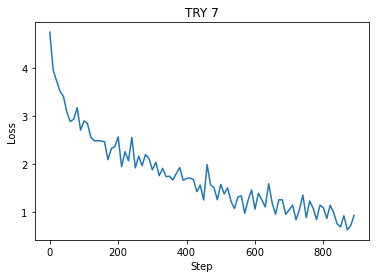

In [19]:
x=np.arange(len(losses))*10
plt.plot(x,losses)
plt.title('TRY 7')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

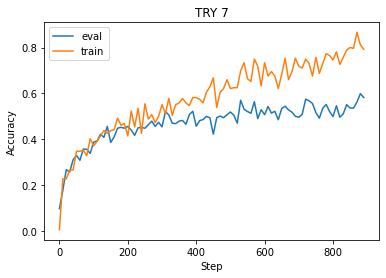

In [20]:
plt.plot(x,eval_accs,label='eval')
plt.plot(x,train_accs,label='train')
plt.title('TRY 7')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
torch.save(cnn3.state_dict(),'CNN3 3.pkl')

In [22]:
train_acc=[]
for x,y in train_loader:
    b_x=Variable(x).cuda()
    b_y=Variable(y).cuda()        
    output=cnn3(b_x)
    pred_y=torch.max(output,1)[1].cuda().data.squeeze()
    accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
    train_acc.append(accuracy)
train_acc

[0.8984375,
 0.85546875,
 0.859375,
 0.85546875,
 0.85546875,
 0.83203125,
 0.8359375,
 0.81640625,
 0.8359375,
 0.81640625,
 0.8515625,
 0.875,
 0.85546875,
 0.83984375,
 0.83203125,
 0.83203125,
 0.83203125,
 0.83984375,
 0.828125,
 0.8515625,
 0.828125,
 0.83984375,
 0.8515625,
 0.8359375,
 0.8888888888888888]

In [23]:
eval_acc=[]
for x,y in eval_loader:
    b_x=Variable(x).cuda()
    b_y=Variable(y).cuda()        
    output=cnn3(b_x)
    pred_y=torch.max(output,1)[1].cuda().data.squeeze()
    accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
    eval_acc.append(accuracy)
eval_acc

[0.59, 0.595, 0.55, 0.555, 0.4]

In [24]:
test_acc=[]
for x,y in eval_loader:
    b_x=Variable(x).cuda()
    b_y=Variable(y).cuda()        
    output=cnn3(b_x)
    pred_y=torch.max(output,1)[1].cuda().data.squeeze()
    accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
    test_acc.append(accuracy)
test_acc

[0.565, 0.565, 0.52, 0.585, 0.5]

In [25]:
np.mean(train_acc)

0.8457118055555556

In [26]:
np.mean(eval_acc)

0.538

In [27]:
np.mean(test_acc)

0.5469999999999999